# AIS Trajectory

### Importere biblioteker

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from mlforecast import MLForecast

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

# Label encoding
from sklearn.preprocessing import LabelEncoder



In [3]:
# Load data
ais_evaluations = pd.read_csv('data/ais_test.csv')
ais_train = pd.read_csv('data/ais_train.csv', sep='|')

# Preprocess data
ais_train['datetime'] = pd.to_datetime(ais_train['time'])
ais_evaluations['datetime'] = pd.to_datetime(ais_evaluations['time'])


# Dropp the vessels that appears less than 100 times 
vessel_counts = ais_train['vesselId'].value_counts().reset_index()
vessel_counts.columns = ['vesselId', 'count']
vessel_counts = vessel_counts[vessel_counts['count'] > 200]

# Convert time to integer
ais_train = ais_train.sort_values("datetime")
ais_train['time'] = ais_train.datetime.astype('int64') // 10**9

ais_evaluations = ais_evaluations.sort_values("datetime")
ais_evaluations['time'] = ais_evaluations.datetime.astype('int64') // 10**9

# Drop etaRaw
ais_train = ais_train.drop(columns=['etaRaw'])


# Create time features and drop datetime
ais_train['hour'] = ais_train['datetime'].dt.hour
ais_train['weekday'] = ais_train['datetime'].dt.weekday
ais_train['month'] = ais_train['datetime'].dt.month
ais_train['year'] = ais_train['datetime'].dt.year

ais_evaluations['hour'] = ais_evaluations['datetime'].dt.hour
ais_evaluations['weekday'] = ais_evaluations['datetime'].dt.weekday
ais_evaluations['month'] = ais_evaluations['datetime'].dt.month
ais_evaluations['year'] = ais_evaluations['datetime'].dt.year

# Drop datetime
ais_train = ais_train.drop(columns=['datetime'])
ais_evaluations = ais_evaluations.drop(columns=['datetime'])

# Label encoder
label_encoder = LabelEncoder()
ais_train['vesselId'] = label_encoder.fit_transform(ais_train['vesselId'])
ais_evaluations['vesselId'] = label_encoder.transform(ais_evaluations['vesselId'])

label_encoder_port = LabelEncoder()
ais_train['portId'] = label_encoder_port.fit_transform(ais_train['portId'])

df = ais_train.copy()


In [4]:
# Display the data
df.head()


,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,hour,weekday,month,year
0,1704067225,284.0,0.7,0,88,0,-34.74370,-57.85130,50,40,0,0,1,2024
1,1704067236,109.6,0.0,-6,347,1,8.89440,-79.47939,189,674,0,0,1,2024
2,1704067305,111.0,11.0,0,112,0,39.19065,-76.47567,432,353,0,0,1,2024
3,1704067391,96.4,0.0,0,142,1,-34.41189,151.02067,110,18,0,0,1,2024
4,1704067431,214.0,19.7,0,215,0,35.88379,-5.91636,356,605,0,0,1,2024


In [5]:
def create_lag_features(df, lags, columns):
    """
    Create lag features for specified columns.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    lags (list): List of lag periods to create.
    columns (list): List of columns to create lag features for.
    
    Returns:
    pd.DataFrame: Dataframe with lag features.
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Define the lags and columns for which to create lag features
lags = [1, 2, 3]
columns = ['cog', 'sog', 'rot', 'heading', 'latitude', 'longitude']

# Create lag features
df = create_lag_features(df, lags, columns)

# Drop rows with missing values
df = df.dropna()

# Display the data with lag features
df.head()

,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,...,rot_lag_3,heading_lag_1,heading_lag_2,heading_lag_3,latitude_lag_1,latitude_lag_2,latitude_lag_3,longitude_lag_1,longitude_lag_2,longitude_lag_3
3,1704067391,96.4,0.0,0,142,1,-34.41189,151.02067,110,18,...,0.0,112.0,347.0,88.0,39.19065,8.89440,-34.74370,-76.47567,-79.47939,-57.85130
4,1704067431,214.0,19.7,0,215,0,35.88379,-5.91636,356,605,...,-6.0,142.0,112.0,347.0,-34.41189,39.19065,8.89440,151.02067,-76.47567,-79.47939
5,1704067513,186.9,0.0,0,187,5,24.27431,-110.32727,591,234,...,0.0,215.0,142.0,112.0,35.88379,-34.41189,39.19065,-5.91636,151.02067,-76.47567
6,1704067540,123.4,0.0,128,511,5,40.71466,29.46603,608,342,...,0.0,187.0,215.0,142.0,24.27431,35.88379,-34.41189,-110.32727,-5.91636,151.02067
7,1704067549,151.2,0.0,0,20,5,-19.25026,146.83507,129,17,...,0.0,511.0,187.0,215.0,40.71466,24.27431,35.88379,29.46603,-110.32727,-5.91636


In [15]:
# Train test split
target = ['latitude', 'longitude']
features = [col for col in df.columns if col not in target]

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=False)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(X_train.columns)
print(y_train.columns)
print(X_test.columns)
print(y_test.columns)

(1217649, 30) (304413, 30) (1217649, 2) (304413, 2)
Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'vesselId', 'portId',
       'hour', 'weekday', 'month', 'year', 'cog_lag_1', 'cog_lag_2',
       'cog_lag_3', 'sog_lag_1', 'sog_lag_2', 'sog_lag_3', 'rot_lag_1',
       'rot_lag_2', 'rot_lag_3', 'heading_lag_1', 'heading_lag_2',
       'heading_lag_3', 'latitude_lag_1', 'latitude_lag_2', 'latitude_lag_3',
       'longitude_lag_1', 'longitude_lag_2', 'longitude_lag_3'],
      dtype='object')
Index(['latitude', 'longitude'], dtype='object')
Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'vesselId', 'portId',
       'hour', 'weekday', 'month', 'year', 'cog_lag_1', 'cog_lag_2',
       'cog_lag_3', 'sog_lag_1', 'sog_lag_2', 'sog_lag_3', 'rot_lag_1',
       'rot_lag_2', 'rot_lag_3', 'heading_lag_1', 'heading_lag_2',
       'heading_lag_3', 'latitude_lag_1', 'latitude_lag_2', 'latitude_lag_3',
       'longitude_lag_1', 'longitude_lag_2', 'longitude_lag_3'],
      dtype='ob

In [ ]:
# Hyperparameter tuning using grid search

from sklearn.model_selection import GridSearchCV

param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)

grid_search.fit(X_train, y_train, verbose=True)

best_params = grid_search.best_params_

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000001E785DCCE50>>
Traceback (most recent call last):
  File "c:\Users\avira\OneDrive - NTNU\Master EMIL\1. semester\ML\TDT4173-Gruppe-8\.venv\Lib\site-packages\xgboost\core.py", line 637, in _next_wrapper
    return self._handle_exception(lambda: self.next(input_data), 0)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\avira\OneDrive - NTNU\Master EMIL\1. semester\ML\TDT4173-Gruppe-8\.venv\Lib\site-packages\xgboost\core.py", line 550, in _handle_exception
    return fn()
           ^^^^
  File "c:\Users\avira\OneDrive - NTNU\Master EMIL\1. semester\ML\TDT4173-Gruppe-8\.venv\Lib\site-packages\xgboost\core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\avira\OneDrive - NTNU\Master 

: 

In [12]:
# Create the model
xgb_model = XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=100
    )

[0]	validation_0-rmse:51.61741
[1]	validation_0-rmse:47.19871
[2]	validation_0-rmse:43.05970
[3]	validation_0-rmse:39.36738
[4]	validation_0-rmse:36.11615
[5]	validation_0-rmse:35.01862
[6]	validation_0-rmse:32.22806
[7]	validation_0-rmse:31.34009
[8]	validation_0-rmse:28.97791
[9]	validation_0-rmse:28.51809
[10]	validation_0-rmse:26.48437
[11]	validation_0-rmse:24.77174
[12]	validation_0-rmse:24.42360
[13]	validation_0-rmse:24.14843
[14]	validation_0-rmse:23.66342
[15]	validation_0-rmse:22.21049
[16]	validation_0-rmse:20.97124
[17]	validation_0-rmse:20.86215
[18]	validation_0-rmse:19.79157
[19]	validation_0-rmse:19.70696
[20]	validation_0-rmse:18.78548
[21]	validation_0-rmse:18.71650
[22]	validation_0-rmse:17.92147
[23]	validation_0-rmse:17.73666
[24]	validation_0-rmse:17.05919
[25]	validation_0-rmse:16.86783
[26]	validation_0-rmse:16.80554
[27]	validation_0-rmse:16.66180
[28]	validation_0-rmse:16.51859
[29]	validation_0-rmse:16.40627
[30]	validation_0-rmse:15.87883
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error: 41.76962062958239
Mean Absolute Error: 2.4472488083475747


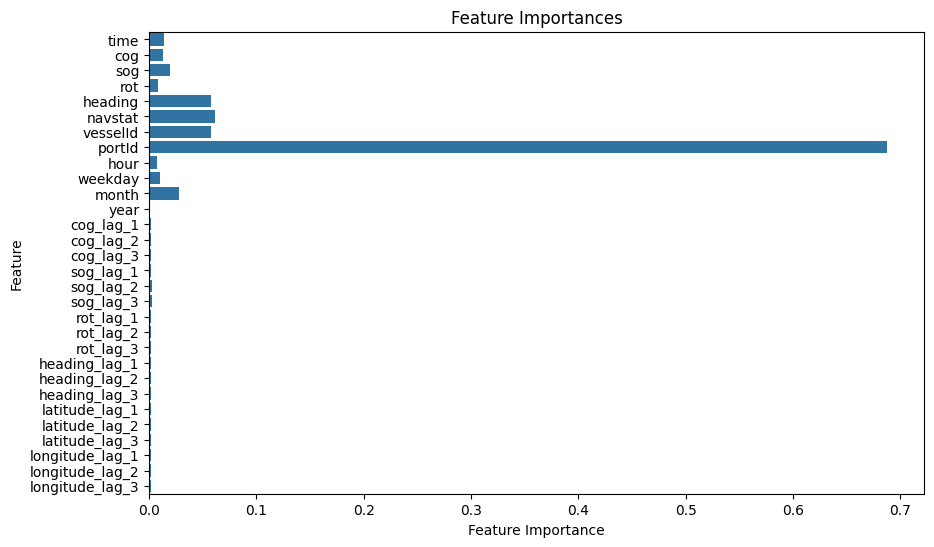

In [19]:
predictions = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))